<h2> CNN with 1 Convolutional Layer - Regularization </h2>

<p>Overfitting is a problem in Deep Neural Networks (DNN): the model learns to classify only the training set, adapting itself to the training examples instead of learning decision boundaries capable of classifying generic instances. </p>
<a>https://pgaleone.eu/deep-learning/regularization/2017/01/10/anaysis-of-dropout/</a>

In [0]:
import glob
import math
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import random
import sklearn.metrics as metrics

import keras
import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, LearningRateScheduler
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import add, concatenate, Conv2D, Dense, Dropout, Flatten, Input
from tensorflow.keras.layers import Activation, AveragePooling2D, BatchNormalization, MaxPooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split

In [20]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
root_path = 'gdrive/My Drive/Colab Notebooks/'  #change dir to your project folder

In [22]:
trDatOrg       = np.load(root_path + 'Flower_Power/flrnonflr-train-imgs224-0.8.npz')['arr_0']
trLblOrg       = np.load(root_path + 'Flower_Power/flrnonflr-train-labels224-0.8.npz')['arr_0']
tsDatOrg       = np.load(root_path + 'Flower_Power/flrnonflr-test-imgs224-0.8.npz')['arr_0']
tsLblOrg       = np.load(root_path + 'Flower_Power/flrnonflr-test-labels224-0.8.npz')['arr_0']

print("For the training and test datasets:")
print("The shapes are %s, %s, %s, %s" \
      %(trDatOrg.shape, trLblOrg.shape, tsDatOrg.shape, tsLblOrg.shape))

For the training and test datasets:
The shapes are (4264, 224, 224, 3), (4264,), (1067, 224, 224, 3), (1067,)


Showing 1027 index image, It is 0.0


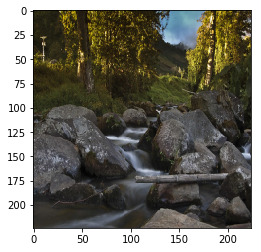

Showing 352 index image, It is 1.0


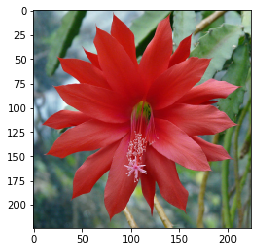

Showing 466 index image, It is 1.0


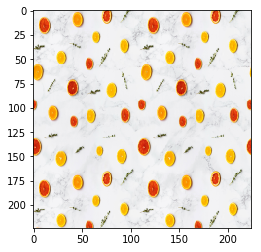

Showing 1004 index image, It is 0.0


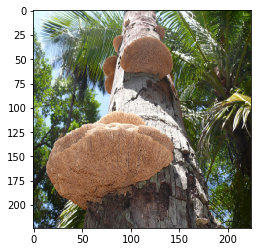

Showing 306 index image, It is 1.0


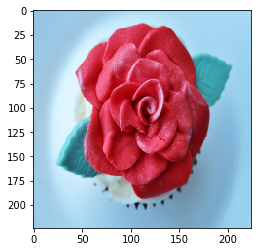

Showing 649 index image, It is 0.0


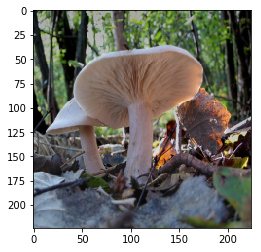

Showing 295 index image, It is 1.0


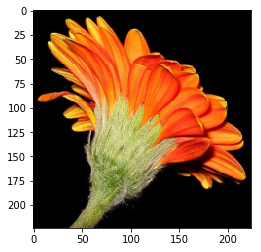

Showing 567 index image, It is 1.0


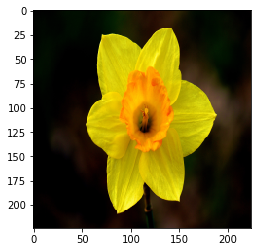

Showing 974 index image, It is 0.0


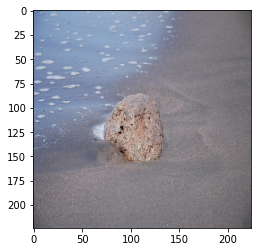

Showing 784 index image, It is 0.0


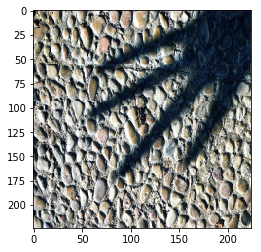

Showing 287 index image, It is 1.0


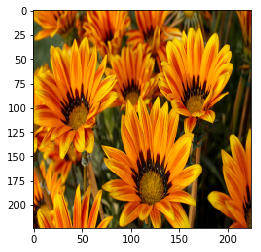

Showing 861 index image, It is 0.0


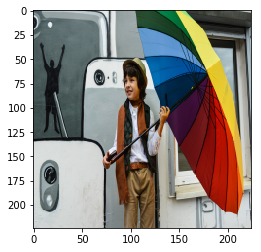

Showing 505 index image, It is 1.0


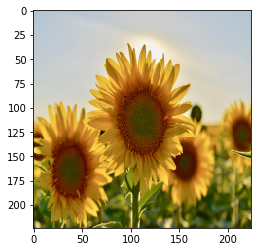

Showing 1005 index image, It is 0.0


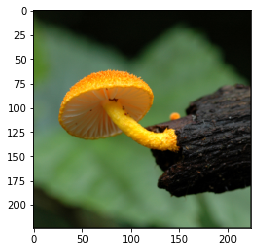

Showing 124 index image, It is 1.0


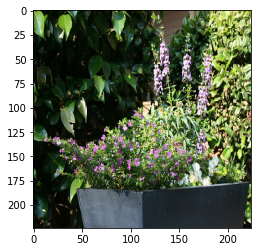

Showing 933 index image, It is 0.0


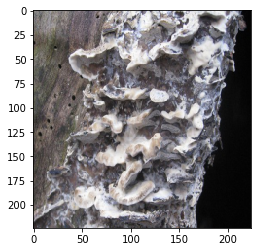

Showing 453 index image, It is 1.0


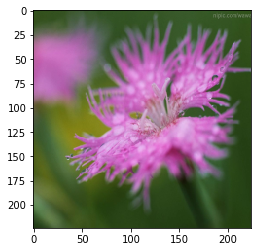

Showing 466 index image, It is 1.0


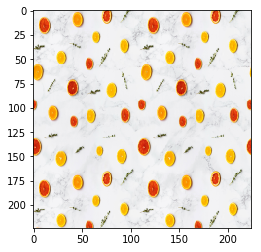

Showing 423 index image, It is 1.0


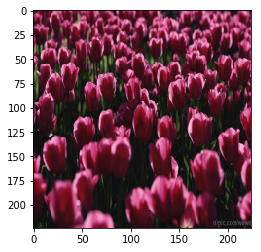

Showing 635 index image, It is 0.0


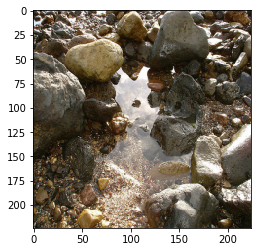

In [23]:
# Randomly show 10 examples of the images

data = tsDatOrg
label = tsLblOrg

for i in range(20):
    index = random.randint(0, len(data)-1)
    print("Showing %s index image, It is %s" %(index, label[index]))
    imgplot = plt.imshow(data[index])
    plt.show()

In [0]:
# Convert the data into 'float32'
# Rescale the values from 0~255 to 0~1
trDat       = trDatOrg.astype('float32')/255
tsDat       = tsDatOrg.astype('float32')/255

# Retrieve the row size of each image
# Retrieve the column size of each image
imgrows     = trDat.shape[1]
imgclms     = trDat.shape[2]
channel     = 3

# Perform one hot encoding on the labels
# Retrieve the number of classes in this problem
trLbl       = to_categorical(trLblOrg)
tsLbl       = to_categorical(tsLblOrg)
num_classes = tsLbl.shape[1]

In [0]:
# Split original training data to sub-training (80%) and validation data (20%)
X_train, X_val, y_train, y_val = train_test_split(trDat, trLbl, test_size=0.2, random_state=13)

In [0]:
# X_test forms the test images, and y_test forms the test labels
X_test = tsDat 
y_test = tsLbl 


<h2> Define Model </h2>

<p>The 1st layer is a Conv2D layer for the convolution operation that extracts features from the input images by sliding a convolution filter over the input to produce a feature map. Here I choose feature map with size 3 x 3.
  
The 2nd layer is a MaxPooling2D layer for the max-pooling operation that reduces the dimensionality of each feature, which helps shorten training time and reduce number of parameters. Here I choose the pooling window with size 2 x 2.
  
The next step is to feed the last output tensor into a stack of Dense layers, otherwise known as fully-connected layers. These densely connected classifiers process vectors, which are 1D, whereas the current output is a 3D tensor. Thus, I need to flatten the 3D outputs to 1D, and then add 2 Dense layers on top.
  
I do a 2-way classification (as there are flowers and non-flowers), using a final layer with 2 outputs and a softmax activation. Softmax activation enables me to calculate the output based on the probabilities. Each class is assigned a probability and the class with the maximum probability is the model’s output for the input. <p>

In [27]:
learning_rate = 0.001
decay_rate = 0.1

adam =tf.keras.optimizers.Adam(lr=learning_rate,decay=decay_rate)

# define the optimizer function
#sgd =  tf.keras.optimizers.SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)

modelname = 'FlowerPower_Base'

def createBaseModel():
  inputs = Input(shape=(imgrows, imgclms, channel))
  x = Conv2D(32, (3, 3), padding='same', activation='relu')(inputs)
  x = MaxPooling2D(pool_size=(2, 2))(x)
  
  x = Flatten()(x) 
  
  x = Dense(128, activation='relu')(x)
  x = Dense(64, activation='relu')(x)
  x = Dense(num_classes, activation='softmax')(x)
  
  model = Model(inputs=[inputs],outputs=x)
  
  model.compile(loss='categorical_crossentropy', 
                  optimizer=adam,
                  metrics=['accuracy'])
  
  return model
  
model = createBaseModel()

model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 112, 112, 32)      0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 401408)            0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               51380352  
_________________________________________________________________
dense_10 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_11 (Dense)             (None, 2)                 130 

<h2> Training the Model </h2>

<p>I train the model with batch size of 64 and 20 epochs on both training and validation data. </p>

In [30]:
# Fit the model
# This is where the training starts
history = model.fit(X_train, y_train,
          batch_size=64,
          epochs=120,
          verbose=1,
          validation_data=(X_val, y_val))

Train on 3411 samples, validate on 853 samples
Epoch 1/120
3411/3411 [==============================] - 8s 2ms/sample - loss: 0.1870 - acc: 0.9531 - val_loss: 0.3713 - val_acc: 0.8265
Epoch 2/120
3411/3411 [==============================] - 8s 2ms/sample - loss: 0.1863 - acc: 0.9534 - val_loss: 0.3746 - val_acc: 0.8253
Epoch 3/120
3411/3411 [==============================] - 8s 2ms/sample - loss: 0.1868 - acc: 0.9507 - val_loss: 0.3811 - val_acc: 0.8230
Epoch 4/120
3411/3411 [==============================] - 8s 2ms/sample - loss: 0.1863 - acc: 0.9531 - val_loss: 0.3750 - val_acc: 0.8242
Epoch 5/120
3411/3411 [==============================] - 8s 2ms/sample - loss: 0.1842 - acc: 0.9554 - val_loss: 0.3699 - val_acc: 0.8300
Epoch 6/120
3411/3411 [==============================] - 8s 2ms/sample - loss: 0.1838 - acc: 0.9554 - val_loss: 0.3696 - val_acc: 0.8300
Epoch 7/120
3411/3411 [==============================] - 8s 2ms/sample - loss: 0.1827 - acc: 0.9563 - val_loss: 0.3722 - val_acc: 0

In [31]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.35094283637088824
Test accuracy: 0.85192126


<h2> Data Augmentation </h2>

This section tests the usefulness of data augmentation in reducing overfitting. 

Data augmentation takes the approach of generating more training data from existing training samples, by augmenting the samples via a number of random transformations that yield believable-looking images. The goal is that at training time, the model will never see the exact same picture twice. This helps expose the model to more aspects of the data and generalize better.

In Keras, this can be done by configuring a number of random transformations to be performed on the images read by the ImageDataGenerator instance.

1. rotation_range is a value in degrees (0–180), a range within which to randomly rotate pictures.
2. width_shift and height_shift are ranges (as a fraction of total width or height) within which to randomly translate pictures vertically or horizontally.
3. shear_range is for randomly applying shearing transformations.
4. zoom_range is for randomly zooming inside pictures.

In [0]:
from keras.preprocessing.image import ImageDataGenerator

gen = ImageDataGenerator(rotation_range=8, width_shift_range=0.08, shear_range=0.3,
                               height_shift_range=0.08, zoom_range=0.08)

batches = gen.flow(X_train, y_train, batch_size=64)
val_batches = gen.flow(X_val, y_val, batch_size=64)

In [36]:
history1 = model.fit_generator(batches, steps_per_epoch=3411//64, epochs=100,
                    validation_data=val_batches, validation_steps=853//64, use_multiprocessing=True)

Epoch 1/100
53/53 [==============================] - 53s 997ms/step - loss: 0.3248 - acc: 0.8650 - val_loss: 0.3805 - val_acc: 0.8269
Epoch 2/100
53/53 [==============================] - 52s 988ms/step - loss: 0.3360 - acc: 0.8611 - val_loss: 0.3928 - val_acc: 0.8389
Epoch 3/100
53/53 [==============================] - 52s 980ms/step - loss: 0.3289 - acc: 0.8590 - val_loss: 0.3799 - val_acc: 0.8305
Epoch 4/100
53/53 [==============================] - 52s 987ms/step - loss: 0.3232 - acc: 0.8688 - val_loss: 0.3794 - val_acc: 0.8401
Epoch 5/100
53/53 [==============================] - 52s 975ms/step - loss: 0.3191 - acc: 0.8718 - val_loss: 0.3870 - val_acc: 0.8185
Epoch 6/100
53/53 [==============================] - 52s 980ms/step - loss: 0.3184 - acc: 0.8688 - val_loss: 0.3766 - val_acc: 0.8365
Epoch 7/100
53/53 [==============================] - 52s 976ms/step - loss: 0.3252 - acc: 0.8709 - val_loss: 0.3729 - val_acc: 0.8450
Epoch 8/100
53/53 [==============================] - 51s 968ms

In [37]:
score1 = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score1[0])
print('Test accuracy:', score1[1])

Test loss: 0.34916490571959174
Test accuracy: 0.8509841


<h2> Results </h2>

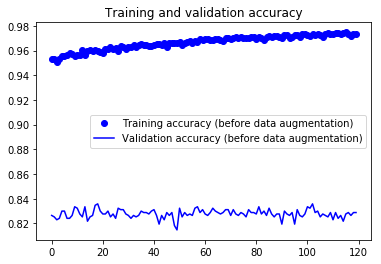

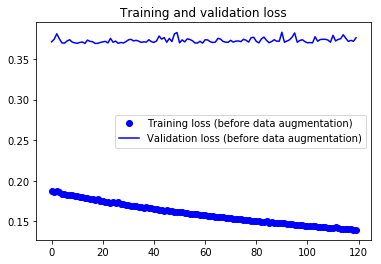

In [38]:
#plot graphs to interpret the results (before data augmentation)

accuracy_org = history.history['acc']
val_accuracy_org = history.history['val_acc']
loss_org = history.history['loss']
val_loss_org = history.history['val_loss']
epochs_org = range(len(accuracy_org))

plt.plot(epochs_org, accuracy_org, 'bo', label='Training accuracy (before data augmentation)')
plt.plot(epochs_org, val_accuracy_org, 'b', label='Validation accuracy (before data augmentation)')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs_org, loss_org, 'bo', label='Training loss (before data augmentation)')
plt.plot(epochs_org, val_loss_org, 'b', label='Validation loss (before data augmentation)')
plt.title('Training and validation loss')
plt.legend()
plt.show()

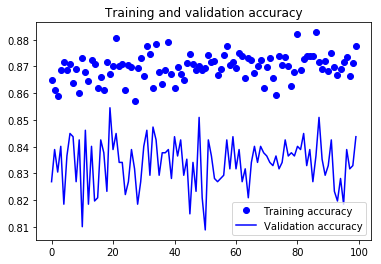

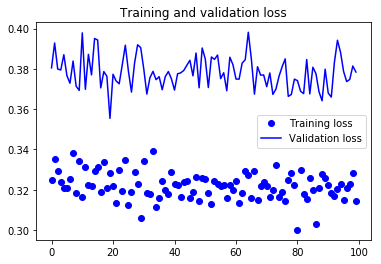

In [39]:
#plot graphs to interpret the results (after data augmentation)

accuracy = history1.history['acc']
val_accuracy = history1.history['val_acc']
loss = history1.history['loss']
val_loss = history1.history['val_loss']
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

<p> Data Augumentation reduces overfitting </p>

<h2> Classification Results </h2>

In [40]:
# Make classification on the test dataset
predicts    = model.predict(X_test)

# Prepare the classification output
# for the classification report
predout     = np.argmax(predicts,axis=1)
testout     = np.argmax(y_test,axis=1)

# the labels for the classfication report
labelname   = ['flower', 'non-flower']


testScores  = metrics.accuracy_score(testout,predout)
confusion   = metrics.confusion_matrix(testout,predout)


print("Best accuracy (on testing dataset): %.2f%%" % (testScores*100))
print(metrics.classification_report(testout,predout,target_names=labelname,digits=4))
print(confusion)

Best accuracy (on testing dataset): 85.10%
              precision    recall  f1-score   support

      flower     0.8016    0.8634    0.8314       454
  non-flower     0.8927    0.8418    0.8665       613

    accuracy                         0.8510      1067
   macro avg     0.8472    0.8526    0.8489      1067
weighted avg     0.8540    0.8510    0.8516      1067

[[392  62]
 [ 97 516]]


To combat overfititng, I add a Dropout layer as the 3rd layer, a powerful regularization technique. Dropout is the method used to reduce overfitting. It forces the model to learn multiple independent representations of the same data by randomly disabling neurons in the learning phase. In this model, dropout will randomnly disable 20% of the neurons.

<p> Dropout is a regularization technique, and is most effective at preventing overfitting. <b> However, there are several places when dropout can hurt performance.</b>
 
1.   Right before the last layer. This is generally a bad place to apply dropout, because the network has no ability to "correct" errors induced by dropout before the classification happens. <br>
  
2.   When the network is small relative to the dataset, regularization is usually unnecessary. If the model capacity is already low, lowering it further by adding regularization will hurt performance. I noticed most of your networks were relatively small and shallow. <br>
  
3.  When training time is limited.Usually dropout hurts performance at the start of training, but results in the final ''converged'' error being lower. Therefore, if we don't plan to train until convergence, you may not want to use dropout.  </p>